In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import sqlite3 as sql
import geopandas as gpd
import folium
from shapely.geometry import point
from folium.plugins import MarkerCluster

%matplotlib inline

## Imported CSV files to dataframes

In [2]:
incident_response = pd.read_csv('../Data/charts_clean.csv')
incident_response.head()

,Month,Precinct,ASSIST EMS,DISORDERLY SUBJECT,DOMESTIC DISTURBANCE,INTOXICATED PERSON,MENTAL CONDITION,SUICIDAL PERSON,SUSPICIOUS PERSON,TRESPASSER,...,Priority_2L,Priority_2M,Priority_2N,Priority_2T,Priority_2R,Priority_3,Priority_3H,Priority_3M,Priority_3Q,Total Response
0,August,C,203,354,11,7,28,43,18,104,...,0,251,0,0,0,21,0,1,0,853
1,August,CMD1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,August,CW,3,8,0,0,1,1,1,3,...,0,17,0,0,0,0,0,0,0,19
3,August,E,91,187,56,3,13,16,44,33,...,0,126,0,0,0,12,0,2,0,531
4,August,H,190,310,64,5,28,31,69,68,...,0,190,0,0,0,32,0,4,0,955


In [3]:
calls_address = pd.read_csv('../Data/calls_clean.csv')
calls_address.head()

,Month,Precinct,Date,Created,Address,Incident Type,Priority
0,July,C,07-01-2021,01:57:16,639 LAFAYETTE ST,INTOXICATED PERSON,2
1,July,C,07-01-2021,03:02:52,920 BROADWAY,WELFARE CHECK,2
2,July,C,07-01-2021,05:44:47,110 4TH AVE S,DISORDERLY SUBJECT,2
3,July,C,07-01-2021,05:49:07,800 4TH AVE S,SUSPICIOUS PERSON,2
4,July,C,07-01-2021,08:01:06,1033 DEMONBREUN ST,TRESPASSER,2


In [4]:
geo_clean = pd.read_csv('../Data/geocodeclean.csv')
geo_clean.head()

,address,lat,lng
0,1022 SEYMOUR AVE,36.185726,-86.750575
1,1310 EASTLAND AVE,36.183276,-86.745370
2,617 S 5TH ST,36.165976,-86.760884
3,2409 EMMETT AVE,36.195349,-86.747668
4,2930 DICKERSON PIKE,36.223448,-86.761631


## Merged geo data to calls/address

In [5]:
geo_calls_merged = pd.merge(geo_clean, calls_address, left_on = 'address', right_on = 'Address')
#geo_calls_merged.drop(['address'], axis=1, inplace = True)
geo_calls_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47926 entries, 0 to 47925
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        47926 non-null  object 
 1   lat            47926 non-null  float64
 2   lng            47926 non-null  float64
 3   Month          47926 non-null  object 
 4   Precinct       47926 non-null  object 
 5   Date           47926 non-null  object 
 6   Created        47926 non-null  object 
 7   Address        47926 non-null  object 
 8   Incident Type  47926 non-null  object 
 9   Priority       47926 non-null  object 
dtypes: float64(2), object(8)
memory usage: 4.0+ MB


## Consolidated priority calls and dropped excess priority columns

In [6]:
incident_response['Priority_2'] = incident_response['Priority_2'] + incident_response['Priority_2L'] + incident_response['Priority_2M'] + incident_response['Priority_2N'] + incident_response['Priority_2T'] + incident_response['Priority_2R']
incident_response['Priority_3'] = incident_response['Priority_3'] + incident_response['Priority_3H'] + incident_response['Priority_3M'] + incident_response['Priority_3Q']
incident_response.drop(['Priority_2L', 'Priority_2M', 'Priority_2N', 'Priority_2T', 'Priority_2R', 'Priority_3H', 'Priority_3M', 'Priority_3Q'], axis=1, inplace = True)
incident_response.head()

,Month,Precinct,ASSIST EMS,DISORDERLY SUBJECT,DOMESTIC DISTURBANCE,INTOXICATED PERSON,MENTAL CONDITION,SUICIDAL PERSON,SUSPICIOUS PERSON,TRESPASSER,WELFARE CHECK,Total Incidents,Priority_1,Priority_2,Priority_3,Total Response
0,August,C,203,354,11,7,28,43,18,104,85,853,2,829,22,853
1,August,CMD1,0,1,0,0,0,0,0,0,0,1,0,1,0,1
2,August,CW,3,8,0,0,1,1,1,3,2,19,0,19,0,19
3,August,E,91,187,56,3,13,16,44,33,88,531,0,517,14,531
4,August,H,190,310,64,5,28,31,69,68,190,955,0,919,36,955


In [7]:
incident_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 87 non-null     object
 1   Precinct              87 non-null     object
 2   ASSIST EMS            87 non-null     int64 
 3   DISORDERLY SUBJECT    87 non-null     int64 
 4   DOMESTIC DISTURBANCE  87 non-null     int64 
 5   INTOXICATED PERSON    87 non-null     int64 
 6   MENTAL CONDITION      87 non-null     int64 
 7   SUICIDAL PERSON       87 non-null     int64 
 8   SUSPICIOUS PERSON     87 non-null     int64 
 9   TRESPASSER            87 non-null     int64 
 10  WELFARE CHECK         87 non-null     int64 
 11  Total Incidents       87 non-null     int64 
 12  Priority_1            87 non-null     int64 
 13  Priority_2            87 non-null     int64 
 14  Priority_3            87 non-null     int64 
 15  Total Response        87 non-null     int6

In [8]:
calls_per_precinct = incident_response.groupby('Precinct')['Total Incidents'].sum().to_frame()
calls_per_precinct = calls_per_precinct.sort_values('Total Incidents', ascending = False)
calls_per_precinct

,Total Incidents
Precinct,
H,7957
S,7953
C,6870
MT,5973
N,5515
M,4867
E,4408
W,4258
CW,118


<AxesSubplot:xlabel='Precinct'>

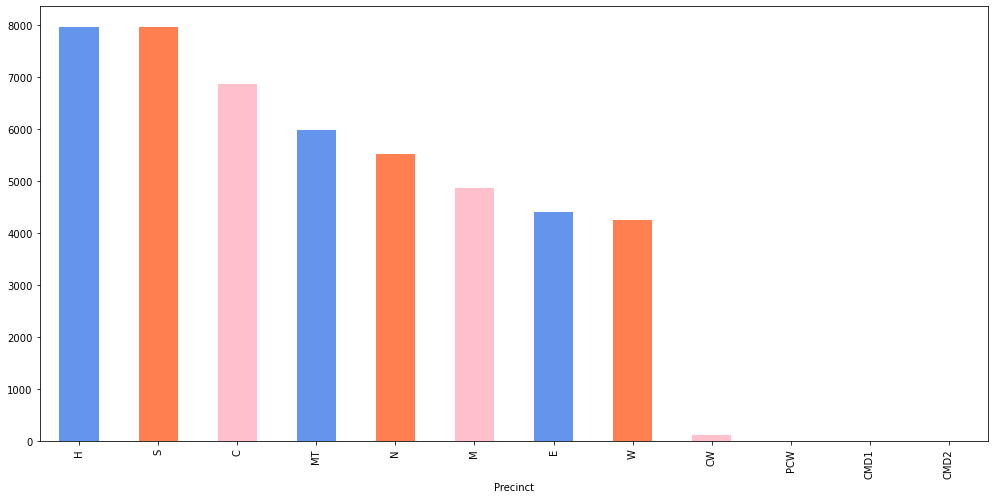

In [9]:
calls_per_precinct['Total Incidents'].plot(kind = 'bar',
                                    figsize = (17,8), color =['cornflowerblue', 'coral', 'pink'])

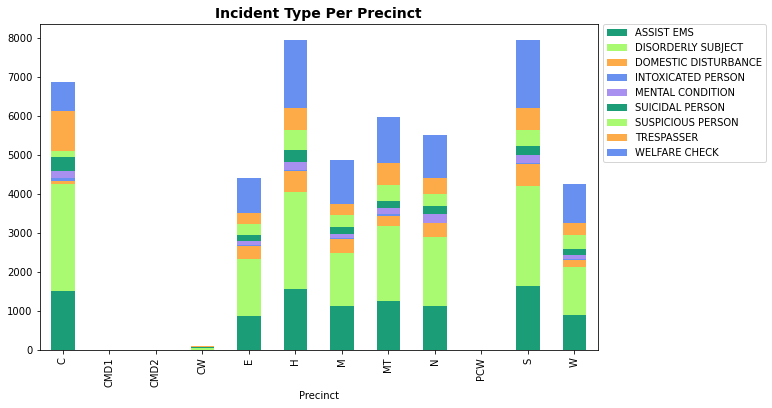

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
incident_type_precinct = pd.crosstab(geo_calls_merged.Precinct, geo_calls_merged['Incident Type'])
incident_type_precinct.plot(kind='bar', stacked=True, ax=ax, color = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0'])
plt.legend(bbox_to_anchor = (1, 1.015), loc = 'upper left')
plt.title('Incident Type Per Precinct',
         fontsize = 14,
         fontweight = 'bold')
plt.show()

In [11]:
precinct_priority = incident_response.groupby('Precinct')['Priority_1', 'Priority_2', 'Priority_3'].sum()
precinct_priority 

C:\Users\kylem\AppData\Local\Temp\ipykernel_24848\3457885313.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  precinct_priority = incident_response.groupby('Precinct')['Priority_1', 'Priority_2', 'Priority_3'].sum()


,Priority_1,Priority_2,Priority_3
Precinct,,,
C,7,6638,225
CMD1,0,1,1
CMD2,0,1,0
CW,0,112,6
E,4,4216,188
H,9,7597,351
M,1,4630,236
MT,2,5823,148
N,2,5227,286


In [12]:
precinct_priority.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, C to W
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Priority_1  12 non-null     int64
 1   Priority_2  12 non-null     int64
 2   Priority_3  12 non-null     int64
dtypes: int64(3)
memory usage: 384.0+ bytes


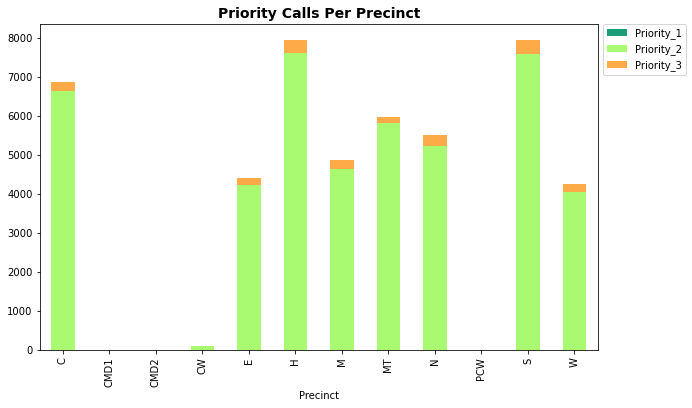

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
precinct_priority.plot(kind='bar', stacked=True, ax=ax, color = ['#1b9e77', '#a9f971', '#fdaa48'])
plt.legend(bbox_to_anchor = (1, 1.015), loc = 'upper left')
plt.title('Priority Calls Per Precinct',
         fontsize = 14,
         fontweight = 'bold')
plt.show()

In [14]:
conn = sql.connect('../Data/census.sqlite')
cur = conn.cursor()

In [15]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")

In [16]:
available_tables = (cur.fetchall())
print(available_tables)

[('B01001',), ('B03002',), ('B11001',), ('B11002',), ('B15002',), ('B19001',), ('B19013',), ('B19301',), ('B25024',), ('B25075',), ('S1701',)]


In [17]:
cur.execute('SELECT * FROM B01001 LIMIT 5;')

pop_age_sex = (cur.fetchall())

In [18]:
type(pop_age_sex)

list

In [19]:
pop_age_sex = pd.read_sql("SELECT * FROM B01001;", conn)
pop_age_sex

,index,GEO_ID,NAME,tract,county,state,variable,value,description
0,0,1400000US47037010103,"Census Tract 101.03, Davidson County, Tennessee",10103,37,47,B01001_001E,2533,Estimate!!Total:
1,1,1400000US47037010104,"Census Tract 101.04, Davidson County, Tennessee",10104,37,47,B01001_001E,2955,Estimate!!Total:
2,2,1400000US47037010105,"Census Tract 101.05, Davidson County, Tennessee",10105,37,47,B01001_001E,4435,Estimate!!Total:
3,3,1400000US47037010106,"Census Tract 101.06, Davidson County, Tennessee",10106,37,47,B01001_001E,3397,Estimate!!Total:
4,4,1400000US47037010201,"Census Tract 102.01, Davidson County, Tennessee",10201,37,47,B01001_001E,4157,Estimate!!Total:
...,...,...,...,...,...,...,...,...,...
7884,7884,1400000US47037019400,"Census Tract 194, Davidson County, Tennessee",19400,37,47,B01001_049E,53,Estimate!!Total:!!Female:!!85 years and over
7885,7885,1400000US47037019500,"Census Tract 195, Davidson County, Tennessee",19500,37,47,B01001_049E,0,Estimate!!Total:!!Female:!!85 years and over
7886,7886,1400000US47037019600,"Census Tract 196, Davidson County, Tennessee",19600,37,47,B01001_049E,68,Estimate!!Total:!!Female:!!85 years and over
7887,7887,1400000US47037980100,"Census Tract 9801, Davidson County, Tennessee",980100,37,47,B01001_049E,0,Estimate!!Total:!!Female:!!85 years and over


In [20]:
#pop_age_sex.to_excel('sample_test.xlsx')

In [22]:
#geo_calls_merged.to_excel('crime_data.xlsx')

In [23]:
cur.execute('SELECT * FROM B03002 LIMIT 5;')

table_2 = (cur.fetchall())

In [24]:
table_2

[(0,
  '1400000US47037010103',
  'Census Tract 101.03, Davidson County, Tennessee',
  10103,
  37,
  47,
  'B03002_001E',
  2533,
  'Estimate!!Total:'),
 (1,
  '1400000US47037010104',
  'Census Tract 101.04, Davidson County, Tennessee',
  10104,
  37,
  47,
  'B03002_001E',
  2955,
  'Estimate!!Total:'),
 (2,
  '1400000US47037010105',
  'Census Tract 101.05, Davidson County, Tennessee',
  10105,
  37,
  47,
  'B03002_001E',
  4435,
  'Estimate!!Total:'),
 (3,
  '1400000US47037010106',
  'Census Tract 101.06, Davidson County, Tennessee',
  10106,
  37,
  47,
  'B03002_001E',
  3397,
  'Estimate!!Total:'),
 (4,
  '1400000US47037010201',
  'Census Tract 102.01, Davidson County, Tennessee',
  10201,
  37,
  47,
  'B03002_001E',
  4157,
  'Estimate!!Total:')]

In [25]:
police_precinct_map = gpd.read_file('../Data/Police District.geojson')
police_precinct_map

,precinct,shape_area,shape_len,geometry
0,CENTRAL,98541971.0257,46234.6717307,"MULTIPOLYGON (((-86.77525 36.14894, -86.77649 ..."
1,EAST,562260180.986,90261.1338967,"MULTIPOLYGON (((-86.74977 36.24057, -86.74955 ..."
2,HERMITAGE,2496337143.44,521944.947628,"MULTIPOLYGON (((-86.61306 36.24427, -86.61038 ..."
3,MADISON,1913402934.01,254564.86409,"MULTIPOLYGON (((-86.74955 36.24047, -86.74977 ..."
4,MIDTOWN-HILLS,1317030605.73,187104.273068,"MULTIPOLYGON (((-86.77935 36.14855, -86.77912 ..."
5,NORTH,3287881220.97,334895.629437,"MULTIPOLYGON (((-86.90742 36.39053, -86.90725 ..."
6,SOUTH,1936875931.39,422441.749973,"MULTIPOLYGON (((-86.63676 36.07248, -86.63664 ..."
7,WEST,3037053503.78,319947.055426,"MULTIPOLYGON (((-86.90759 36.13557, -86.90545 ..."
